In [ ]:
from google.colab import drive
import zipfile
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import uuid
import os

In [ ]:
zip_path = '/content/drive/MyDrive/dataset/dataset.zip'
unzip_path = '/content/bcdataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)


In [ ]:
import os
import pandas as pd

# Load KAUH-BCMD dataset
def load_dataset():
    """
    Loads the KAUH-BCMD dataset from directory structure and simulates metadata.
    Output: DataFrame with columns: image_path, label, patient_id, view, age, density.
    - image_path: Path to 720x720 grayscale JPG mammogram (e.g., /content/bcdataset/BiradX/case_folder/patient_id_view.jpg).
    - label: Binary (0=benign/BI-RADS 1-3, 1=malignant/BI-RADS 4/5).
    - patient_id: Unique patient identifier (e.g., 2019_BC0025182).
    - view: Mammogram view (e.g., R, L, CC, MLO).
    - age: Patient age (integer, 30-80, simulated).
    - density: Breast density (A=1, B=2, C=3, D=4, simulated).

    Dataset Structure:
    - Images: /content/bcdataset/BiradX/case_folder/*.jpg
    - No masks available; full images are processed.
    - BI-RADS labels mapped to binary: 1-3 -> 0 (benign), 4-5 -> 1 (malignant).
    """
    root_dir = '/content/bcdataset'
    data = []
    total_images = 0  # Counter for total images

    for birad_folder in os.listdir(root_dir):
        birad_path = os.path.join(root_dir, birad_folder)
        if os.path.isdir(birad_path) and birad_folder.startswith('Birad'):
            birad_label = int(birad_folder.replace('Birad', ''))
            # Map BI-RADS to binary label
            binary_label = 0 if birad_label in [1, 2, 3] else 1

            for case_folder in os.listdir(birad_path):
                case_path = os.path.join(birad_path, case_folder)
                if os.path.isdir(case_path):
                    for filename in os.listdir(case_path):
                        if filename.endswith('.jpg'):
                            image_path = os.path.join(case_path, filename)

                            # Extract components from filename
                            filename_parts = filename.split('_')
                            patient_id = filename_parts[0] + '_' + filename_parts[1]
                            study_date = filename_parts[0]  # The study date is the first part (e.g., 2013)
                            view = filename_parts[-2]  # Capture 'CC' or 'MLO'
                            breast = filename_parts[-1].replace('.jpg', '')  # 'L' or 'R'

                            data.append({
                                'image_path': image_path,
                                'birads_label': birad_label,
                                'label': binary_label,
                                'patient_id': patient_id,
                                'study_date': study_date,  # Add the study date extracted from filename
                                'view': view,
                                'breast': breast  # Add breast info
                            })
                            total_images += 1

    print(f"Total images loaded from all directories: {total_images}")

    df = pd.DataFrame(data)

    # Load and clean metadata
    metadata = pd.read_csv('/content/bcdataset/metadata.csv')
    print(metadata.columns.tolist())  # For debugging purposes

    # Standardize column names
    metadata = metadata.rename(columns={
        'PatientID': 'patient_id',
        'Patient age ': 'age',
        'Breast  type': 'breast',
        'Breast view': 'view',
        'Percentage of\n grandular tissue(density)': 'density'
    })

    # Merge metadata with image data
    df = df.merge(metadata, on=['patient_id', 'view', 'breast'], how='left')

    # Show summary statistics
    print(f"Total images loaded: {len(df)}")
    print(f"Binary label distribution:\n{df['label'].value_counts()}")
    print(f"BI-RADS label distribution:\n{df['birads_label'].value_counts()}")

    return df


Total images loaded from all directories: 2378


<ipython-input-135-27efd5cce770>:62: DtypeWarning: Columns (0,1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/bcdataset/metadata.csv')


['Study date', 'PatientID', 'Patient age ', 'Breast  type', 'Breast view', 'Percentage of\n grandular tissue(density)', 'Assesment', 'Image path', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
Total images loaded: 2378
Binary label distribution:
label
0    2252
1     126
Name: count, dtype: int64
BI-RADS label distribution:
birads_label
1    1865
3     387
4     102
5      24
Name: count, dtype: int64

Displaying 2 images for Patient ID: 2019_BC0025182


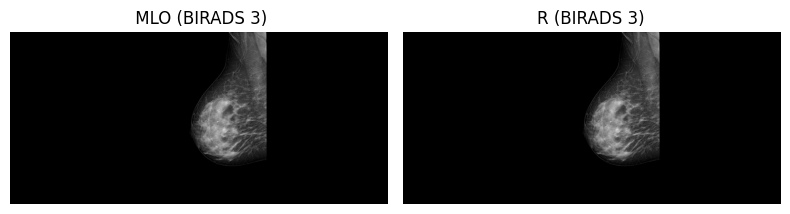


Displaying 4 images for Patient ID: 2017_BC006222


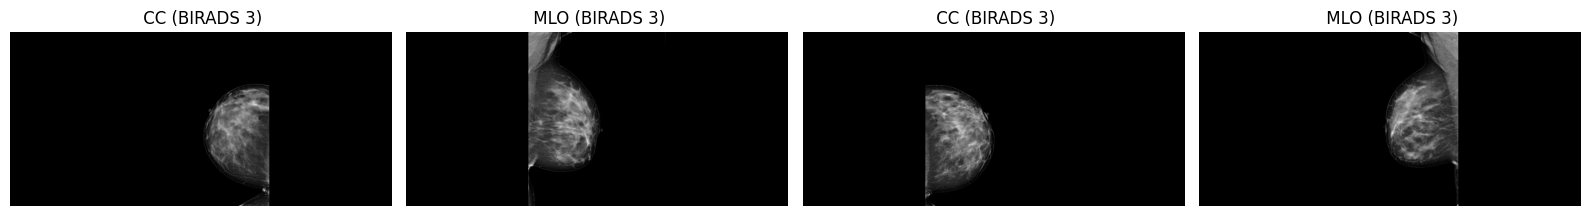


Displaying 4 images for Patient ID: 2018_BC0021726


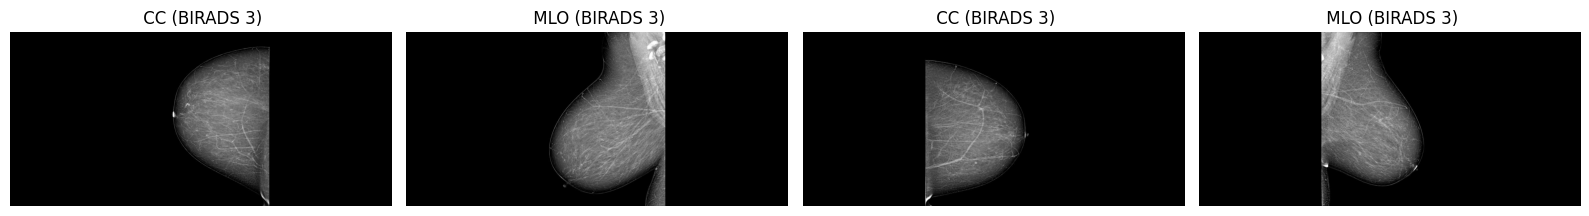


Displaying 4 images for Patient ID: 2018_BC0022661


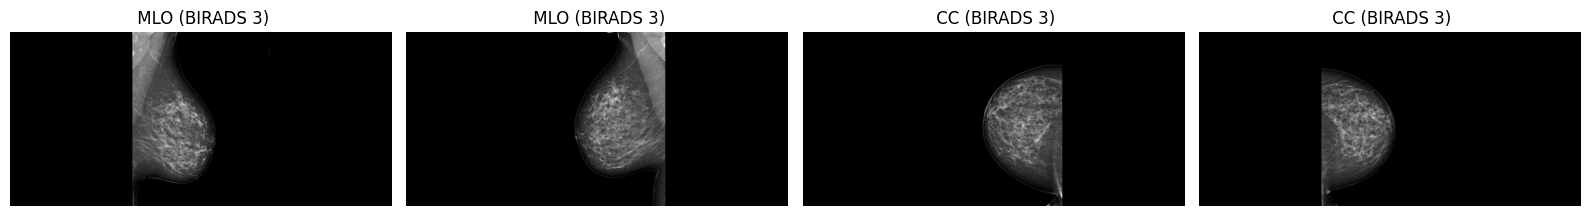


Displaying 4 images for Patient ID: 2017_BC009665


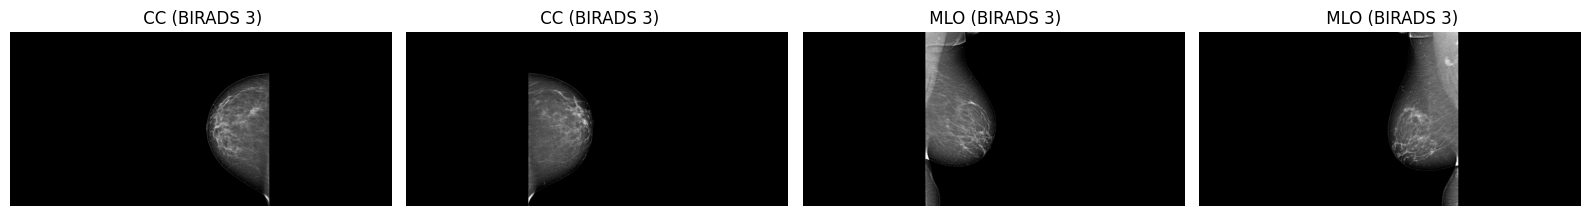


Displaying 4 images for Patient ID: 2018_BC0022862


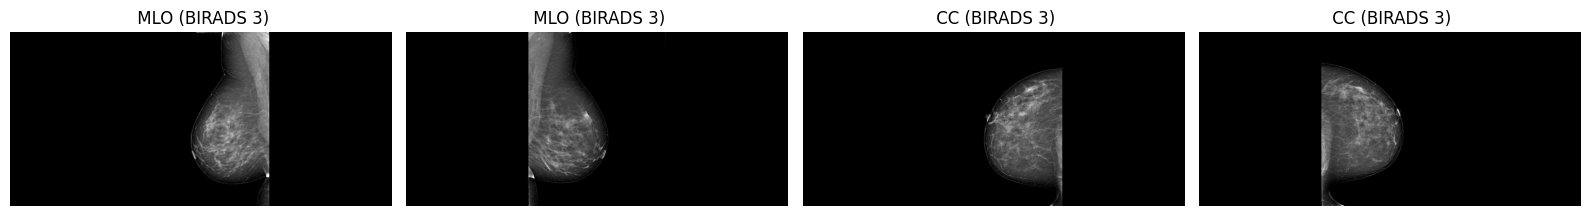


Displaying 4 images for Patient ID: 2018_BC0022121


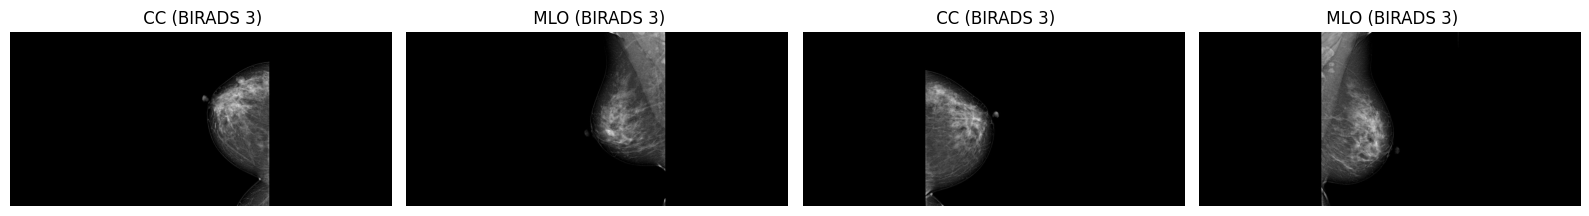


Displaying 4 images for Patient ID: 2018_BC013041


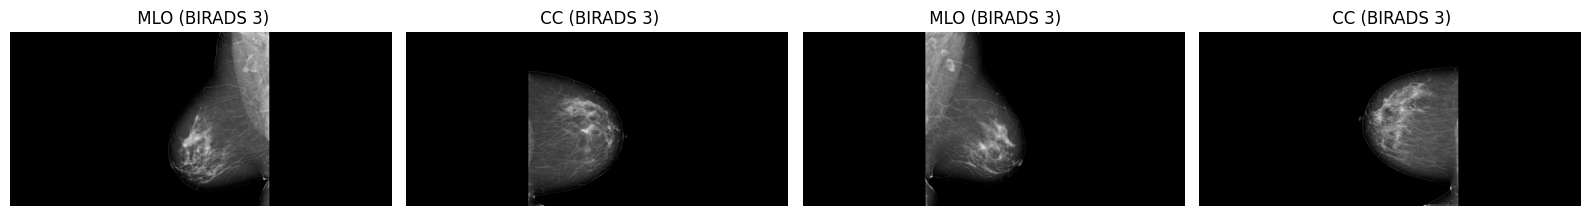


Displaying 4 images for Patient ID: 2016_BC014002


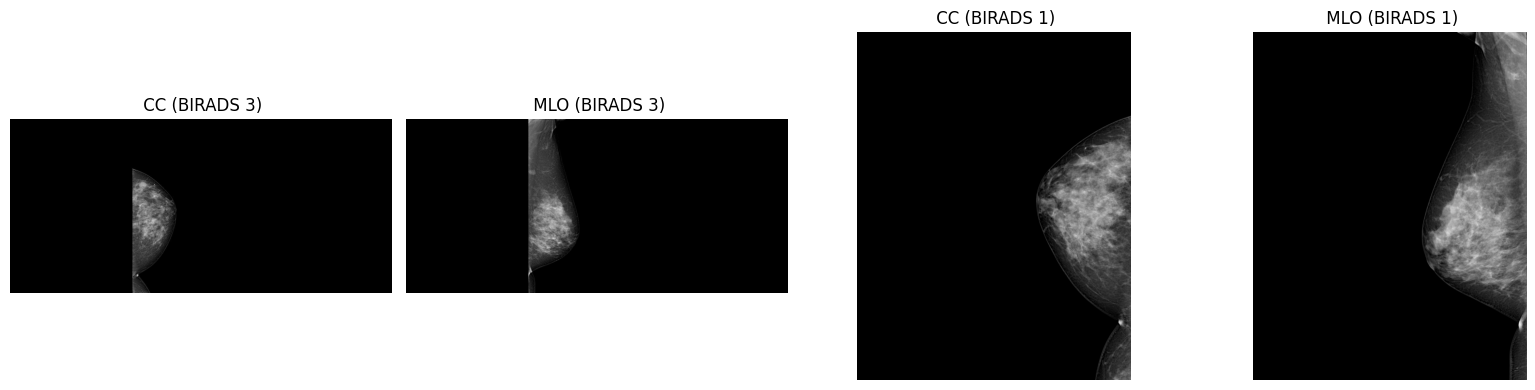


Displaying 4 images for Patient ID: 2017_BC019421


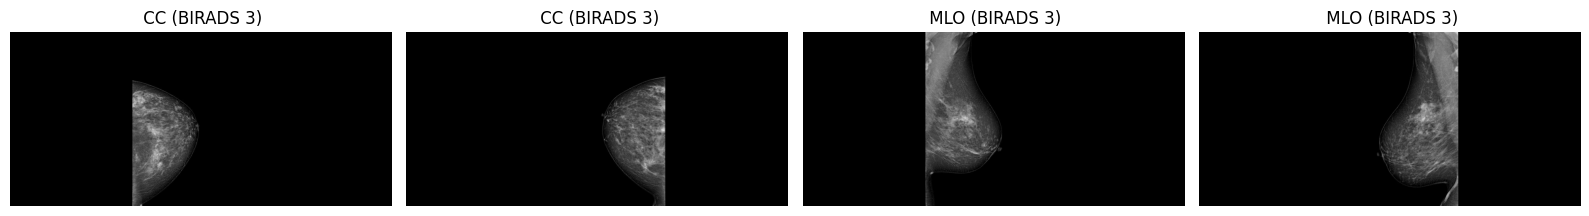

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
df = load_dataset()
# Step 3: Select 3 unique patient IDs
selected_patients = df['patient_id'].unique()[:10]
filtered_df = df[df['patient_id'].isin(selected_patients)]

# Step 4: Plot all images for each of the 3 patients
for pid in selected_patients:
    patient_images = filtered_df[filtered_df['patient_id'] == pid]
    num_images = len(patient_images)

    print(f"\nDisplaying {num_images} images for Patient ID: {pid}")

    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    if num_images == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, patient_images.iterrows()):
        img = Image.open(row['image_path'])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{row['view']} (BIRADS {row['birads_label']})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocessing function for mammogram images
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocesses a mammogram image with Gaussian blur, CLAHE, and normalization.
    Input:
    - image_path: Path to grayscale JPG mammogram (720x720).
    - target_size: Final image size (224x224 as per report).
    Output: Preprocessed image (numpy array, 224x224, normalized to [0,1]).

    Steps:
    1. Gaussian blur (σ=1.5) to reduce noise
    2. CLAHE (clip limit=2.0) to enhance contrast.
    3. Resize to 224x224.
    4. Min-max normalization

    """
    # Load image (grayscale)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # 1. Gaussian blur (σ=1.5)
    image = cv2.GaussianBlur(image, (5, 5), sigmaX=1.5)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

 #édited to remove ROI extraction due to absence of masks

    # 3. Resize to 224x224
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # 4. Min-max normalization
    image = (image - image.min()) / (image.max() - image.min() + 1e-6)

    return image

In [ ]:
def extract_features(df):
    """
    Extracts HOG features and combines with metadata (age, density).
    Input: DataFrame with image_path, label, age, density.
    Output:
    - X: Feature matrix (HOG features + age + density).
    - y: Binary labels (0=benign, 1=malignant).

    HOG (Histogram of Oriented Gradients):
    - Computes gradient orientations in 8x8 cells, grouped into blocks.
    - Yields 1,024 features per 224x224 image (as per report).
    """
    X_hog = []
    X_meta = []
    y = []

    for _, row in df.iterrows():
        try:
            # Preprocess image
            image = preprocess_image(row['image_path'])

            # Extract HOG features
            hog_features = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
            X_hog.append(hog_features)

            # Metadata features
            X_meta.append([row['age'], row['density']])
            y.append(row['label'])
        except Exception as e:
            print(f"Error processing image {row['image_path']}: {e}")
            continue

    # Combine HOG and metadata
    X = np.hstack([np.array(X_hog), np.array(X_meta)])
    y = np.array(y)

    return X, y


In [ ]:
from sklearn.impute import SimpleImputer

def apply_smote(X, y):
    # Impute missing values with column mean
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    smote = SMOTE(sampling_strategy=0.6667, random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_imputed, y)

    return X_balanced, y_balanced

In [ ]:
# Feature selection and dimensionality reduction
def apply_feature_selection(X, y, method='selectkbest', n_features=100):
    """
    Applies SelectKBest or PCA to reduce features to 100.
    Input:
    - X: Feature matrix.
    - y: Labels.
    - method: 'selectkbest' (chi-squared) or 'pca'.
    - n_features: Number of features to retain (100 as per report).
    Output: Transformed X.

    SelectKBest:
    - Selects top k features based on chi-squared scores
    PCA:
    - Reduces to components retaining 95% variance: X_PCA = XW, where W are principal components.
    """
    if method == 'selectkbest':
        # Ensure non-negative features for chi2
        X = np.maximum(X, 0)
        selector = SelectKBest(score_func=chi2, k=n_features)
        X = selector.fit_transform(X, y)
    elif method == 'pca':
        pca = PCA(n_components=n_features, random_state=42)
        X = pca.fit_transform(X)
    return X

In [ ]:
# Model training and evaluation
def train_decision_tree(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates Decision Tree with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    Decision Tree:
    - Splits data based on feature thresholds, minimizing Gini impurity.
 PENDAKAN - Tuned for max_depth = [3, 5, 10].
    """
    max_depths = [3, 5, 10]
    results = []

    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'max_depth': depth,
            'train_acc': accuracy_score(y_train, model.predict(X_train)),
            'val_acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results)
    best_model = DecisionTreeClassifier(max_depth=results_df.loc[results_df['val_acc'].idxmax(), 'max_depth'], random_state=42)
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
def train_knn(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates KNN with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    KNN:
    - Classifies based on k nearest neighbors.
    - Tuned for k = [3, 5, 7].
    """
    ks = [i for i in range(1, 15)]
    results = []

    for k in ks:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'k': k,
            'train_acc': accuracy_score(y_train, model.predict(X_train)),
            'val_acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results)
    best_model = KNeighborsClassifier(n_neighbors=results_df.loc[results_df['val_acc'].idxmax(), 'k'])
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
def train_naive_bayes(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates Naïve Bayes with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    Naïve Bayes:
    - Assumes feature independence, uses Bayes' theorem: P(C|X) = P(X|C)P(C)/P(X).
    - Tuned for var_smoothing = [1e-9, 1e-8].
    """
    smoothings = [1e-9, 1e-8]
    results = []

    for smoothing in smoothings:
        model = GaussianNB(var_smoothing=smoothing)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'smoothing': smoothing,
            'train_acc': accuracy_score(y_train, model.predict(X_train)),
            'val_acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results)
    best_model = GaussianNB(var_smoothing=results_df.loc[results_df['val_acc'].idxmax(), 'smoothing'])
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates Logistic Regression with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    Logistic Regression:
    - Models probability with sigmoid: P(y=1|X) = 1/(1 + e^-(β_0 + β_1X)).
    - Tuned for C = [0.1, 1.0, 10.0].
    """
    Cs = [0.1, 1.0, 10.0]
    results = []

    for C in Cs:
        model = LogisticRegression(C=C, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'C': C,
            'train_acc': accuracy_score(y_train, model.predict(X_train)),
            'val_acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred)
        })

    results_df = pd.DataFrame(results)
    best_model = LogisticRegression(C=results_df.loc[results_df['val_acc'].idxmax(), 'C'], max_iter=1000, random_state=42)
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
def train_svm_linear(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates SVM (linear kernel) with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    SVM (Linear):
    - Maximizes margin: f(x) = w^T x + b.
    - Tuned for C = [0.1, 1.0, 10.0].
    """
    Cs = [0.1, 1.0, 10.0]
    results = []

    for C in Cs:
        model = SVC(kernel='linear', C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'C': C,
            'train_acc': accuracy_score(y_train, model.predict(X_train)),
            'val_acc': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        })

    results_df = pd.DataFrame(results)
    best_model = SVC(kernel='linear', C=results_df.loc[results_df['val_acc'].idxmax(), 'C'], probability=True, random_state=42)
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
def train_svm_rbf(X_train, y_train, X_test, y_test):
    """
    Trains and evaluates SVM (RBF kernel) with hyperparameter tuning.
    Input: Train/test features and labels.
    Output: Best model metrics and tuning results.

    SVM (RBF):
    - Uses RBF kernel: K(x_i, x_j) = e^(-γ||x_i - x_j||^2).
    - Tuned for C = [0.1, 1.0, 10.0], γ = [0.01, 0.1].
    """
    Cs = [0.1, 1.0, 10.0]
    gammas = [0.01, 0.1]
    results = []

    for C in Cs:
        for gamma in gammas:
            model = SVC(kernel='rbf', C=C, gamma=gamma, probability=True, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            results.append({
                'C': C,
                'gamma': gamma,
                'train_acc': accuracy_score(y_train, model.predict(X_train)),
                'val_acc': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
            })

    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df['val_acc'].idxmax()]
    best_model = SVC(kernel='rbf', C=best_row['C'], gamma=best_row['gamma'], probability=True, random_state=42)
    best_model.fit(X_train, y_train)

    return best_model, results_df

In [ ]:
# Plotting functions
def plot_hyperparameter_tuning(results_df, param_name, model_name):
    """
    Plots training and validation accuracy vs. hyperparameter.
    Input:
    - results_df: DataFrame with tuning results.
    - param_name: Hyperparameter name (e.g., 'max_depth').
    - model_name: Model name for title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(results_df[param_name], results_df['train_acc'], label='Training Accuracy')
    plt.plot(results_df[param_name], results_df['val_acc'], label='Validation Accuracy')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'{model_name}: Accuracy vs. {param_name}')
    plt.legend()
    plt.savefig(f'{model_name}_tuning.png')
    plt.close()

In [ ]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    """
    Plots confusion matrix for the best model.
    Input:
    - y_test: True labels.
    - y_pred: Predicted labels.
    - model_name: Model name for title.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()

In [ ]:
def plot_pca_variance(pca):
    """
    Plots PCA explained variance ratio.
    Input: Fitted PCA object.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.savefig('pca_variance.png')
    plt.close()


In [ ]:
# Main execution
def main():
    """
    Main function to run the breast cancer detection pipeline and print evaluation metrics.
    Steps:
    1. Load and preprocess data.
    2. Extract features (HOG + metadata).
    3. Apply SMOTE.
    4. Feature selection (SelectKBest, PCA).
    5. Train and evaluate traditional ML models (Decision Tree, KNN, Naïve Bayes, Logistic Regression, SVM Linear, SVM RBF).
    6. Print metrics for each model and final summary.
    7. Generate plots.
    """
    df = load_dataset()
    X, y = extract_features(df)
    X, y = apply_smote(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train_select = apply_feature_selection(X_train, y_train, method='selectkbest')
    X_test_select = apply_feature_selection(X_test, y_test, method='selectkbest')

    pca = PCA(n_components=100, random_state=42)
    pca.fit(X_train)
    plot_pca_variance(pca)

    models = {
        'Decision Tree': train_decision_tree,
        'KNN': train_knn,
        'Naïve Bayes': train_naive_bayes,
        'Logistic Regression': train_logistic_regression,
        'SVM (Linear)': train_svm_linear,
        'SVM (RBF)': train_svm_rbf
    }

    summary = []

    for name, train_func in models.items():
        print(f"\nTraining {name}...")
        model, results = train_func(X_train_select, y_train, X_test_select, y_test)
        y_pred = model.predict(X_test_select)
        metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC-ROC': roc_auc_score(y_test, model.predict_proba(X_test_select)[:, 1] if name != 'KNN' else model.predict(X_test_select))
        }
        summary.append(metrics)

        # Print metrics for this model
        print(f"\nEvaluation Metrics for {name}:")
        metrics_df = pd.DataFrame([metrics])
        print(metrics_df.to_string(index=False))

        if name == 'Decision Tree':
            plot_hyperparameter_tuning(results, 'max_depth', name)
        elif name == 'KNN':
            plot_hyperparameter_tuning(results, 'k', name)
        elif name == 'Naïve Bayes':
            plot_hyperparameter_tuning(results, 'smoothing', name)
        elif name == 'Logistic Regression' or name == 'SVM (Linear)':
            plot_hyperparameter_tuning(results, 'C', name)
        elif name == 'SVM (RBF)':
            plot_hyperparameter_tuning(results, 'C', name)

        if name == 'SVM (RBF)':
            plot_confusion_matrix(y_test, y_pred, name)

    # Print final summary
    print("\nFinal Performance Summary:")
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))

    summary_df.to_csv('model_performance.csv', index=False)

if __name__ == '__main__':
    main()

Total images loaded from all directories: 2378


<ipython-input-135-27efd5cce770>:62: DtypeWarning: Columns (0,1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/bcdataset/metadata.csv')


['Study date', 'PatientID', 'Patient age ', 'Breast  type', 'Breast view', 'Percentage of\n grandular tissue(density)', 'Assesment', 'Image path', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
Total images loaded: 2378
Binary label distribution:
label
0    2252
1     126
Name: count, dtype: int64
BI-RADS label distribution:
birads_label
1    1865
3     387
4     102
5      24
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [1568 1569]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(



Training Decision Tree...

Evaluation Metrics for Decision Tree:
        Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
Decision Tree  0.665779   0.624365    0.41   0.49497 0.662668

Training KNN...

Evaluation Metrics for KNN:
Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
  KNN  0.355526   0.324427 0.566667  0.412621 0.390872

Training Naïve Bayes...

Evaluation Metrics for Naïve Bayes:
      Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Naïve Bayes  0.633822   0.581699 0.296667  0.392936  0.70711

Training Logistic Regression...

Evaluation Metrics for Logistic Regression:
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.661784   0.612745 0.416667  0.496032 0.600443

Training SVM (Linear)...

Evaluation Metrics for SVM (Linear):
       Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
SVM (Linear)  0.719041   0.639498    0.68  0.659128 0.751648

Training SVM (RBF)...

Evaluation Metrics for SVM (RBF):
    Model 